In [1]:
%pylab inline
from Simulation import *
Vgrid = np.load("richLow.npy")
matplotlib.rcParams['figure.figsize'] = [16, 8]
plt.rcParams.update({'font.size': 15})

Populating the interactive namespace from numpy and matplotlib


### simulation part 

In [2]:
# risk free interest rate depending on current S state 
bondReturn = jnp.array(econRate[:,2])
# stock return depending on current S state
stockReturn = jnp.array(econRate[:,1])

@partial(jit, static_argnums=(0,))
def transition_real(t,a,x):
    '''
        Input:
            x = [w,ab,s,e,o,z] single action 
            x = [0,1, 2,3,4,5] 
            a = [c,b,k,h,action] single state
            a = [0,1,2,3,4]
        Output:
            w_next
            ab_next
            s_next
            e_next
            o_next
            z_next
            
            prob_next
    '''
    s = jnp.array(x[2], dtype = jnp.int8)
    e = jnp.array(x[3], dtype = jnp.int8)
    # actions taken
    b = a[1]
    k = a[2]
    action = a[4]
    w_next = ((1+bondReturn[t])*b + (1+stockReturn[t])*k).repeat(nE)
    ab_next = (1-x[4])*(t*(action == 1)).repeat(nE) + x[4]*(x[1]*jnp.ones(nE))
    s_next = econ[t].repeat(nE)
    e_next = jnp.array([e,(1-e)])
    z_next = x[5]*jnp.ones(nE) + ((1-x[5]) * (k > 0)).repeat(nE)
    # job status changing probability and econ state transition probability
    pe = Pe[s, e]
    prob_next = jnp.array([1-pe, pe])
    # owner
    o_next_own = (x[4] - action).repeat(nE)
    # renter
    o_next_rent = action.repeat(nE)
    o_next = x[4] * o_next_own + (1-x[4]) * o_next_rent   
    return jnp.column_stack((w_next,ab_next,s_next,e_next,o_next,z_next,prob_next))

In [3]:
'''
    x = [w,ab,s,e,o,z]
    x = [5,0, 0,0,0,0]
'''
from jax import random

def simulation(key, period = yearCount):
    initE = random.choice(a = nE, p=E_distribution, key = key)
    initS = random.choice(a = nS, p=S_distribution, key = key) 
    x = [5, 0, initS, initE, 0, 0]
    path = []
    move = []
    for t in range(0, period):
        _, key = random.split(key)
        if t == T_max-1:
            _,a = V_solve(t,Vgrid[:,:,:,:,:,:,t],x)
        else:
            _,a = V_solve(t,Vgrid[:,:,:,:,:,:,t+1],x)
        xp = transition_real(t,a,x)           
        p = xp[:,-1]
        x_next = xp[:,:-1]
        path.append(x)
        move.append(a)
        x = x_next[random.choice(a = nE, p=p, key = key)]
    path.append(x)
    return jnp.array(path), jnp.array(move)

In [4]:
%%time
# total number of agents
num = 10000
# simulation part 
keys = vmap(random.PRNGKey)(jnp.arange(num))
Paths, Moves = vmap(simulation)(keys)

CPU times: user 17min 51s, sys: 2min 58s, total: 20min 50s
Wall time: 3min 44s


In [5]:
# x = [w,ab,s,e,o,z]
# x = [0,1, 2,3,4,5]
ws = Paths[:,:,0].T
ab = Paths[:,:,1].T
ss = Paths[:,:,2].T
es = Paths[:,:,3].T
os = Paths[:,:,4].T
zs = Paths[:,:,5].T
cs = Moves[:,:,0].T
bs = Moves[:,:,1].T
ks = Moves[:,:,2].T
hs = Moves[:,:,3].T
ms = Ms[jnp.array(ab, dtype = jnp.int8)]*os

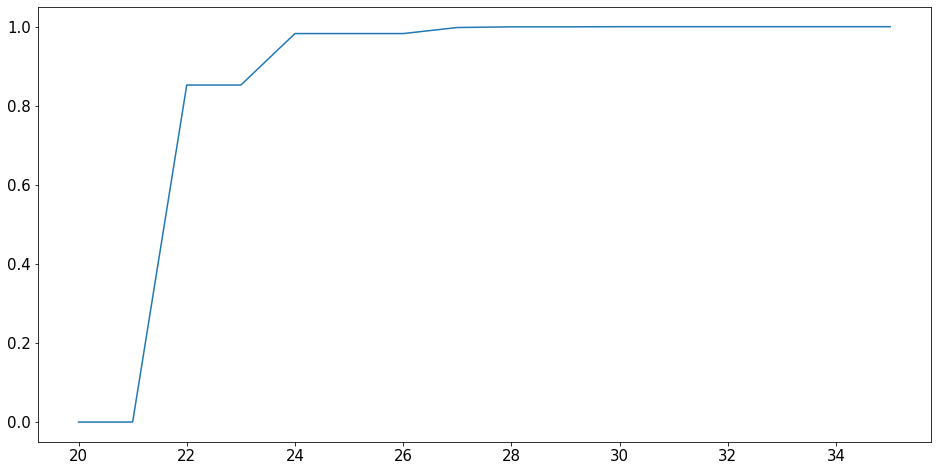

In [6]:
plt.plot(range(20, yearCount + 21),jnp.mean(zs,axis = 1), label = "experience")

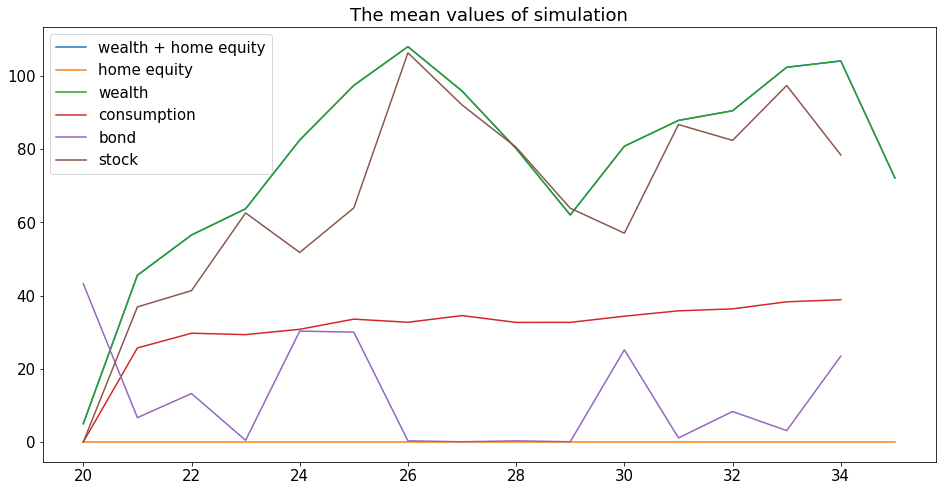

In [7]:
plt.title("The mean values of simulation")
plt.plot(range(20, yearCount + 21),jnp.mean(ws + H*pt*os - ms,axis = 1), label = "wealth + home equity")
plt.plot(range(20, yearCount + 21),jnp.mean(H*pt*os - ms,axis = 1), label = "home equity")
plt.plot(range(20, yearCount + 21),jnp.mean(ws,axis = 1), label = "wealth")
plt.plot(range(20, yearCount + 20),jnp.mean(cs,axis = 1), label = "consumption")
plt.plot(range(20, yearCount + 20),jnp.mean(bs,axis = 1), label = "bond")
plt.plot(range(20, yearCount + 20),jnp.mean(ks,axis = 1), label = "stock")
plt.legend()

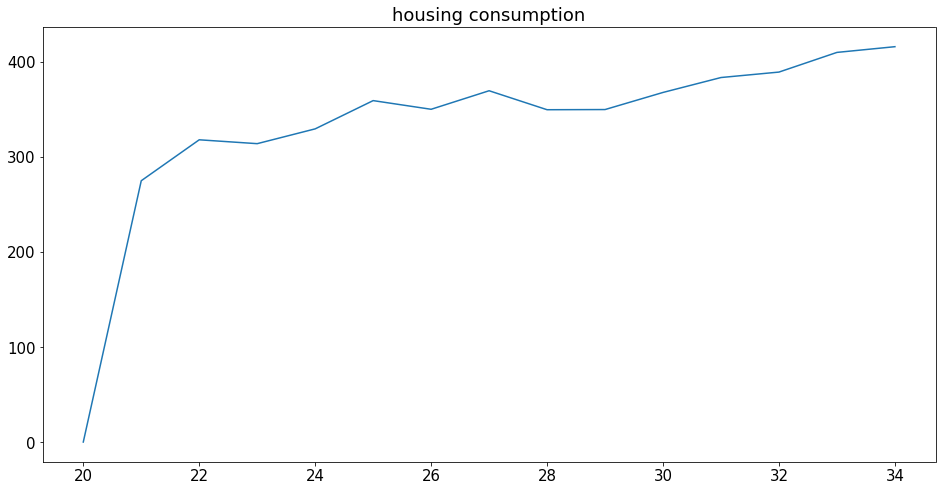

In [8]:
plt.title("housing consumption")
plt.plot(range(20, yearCount + 20),(hs).mean(axis = 1), label = "housing")

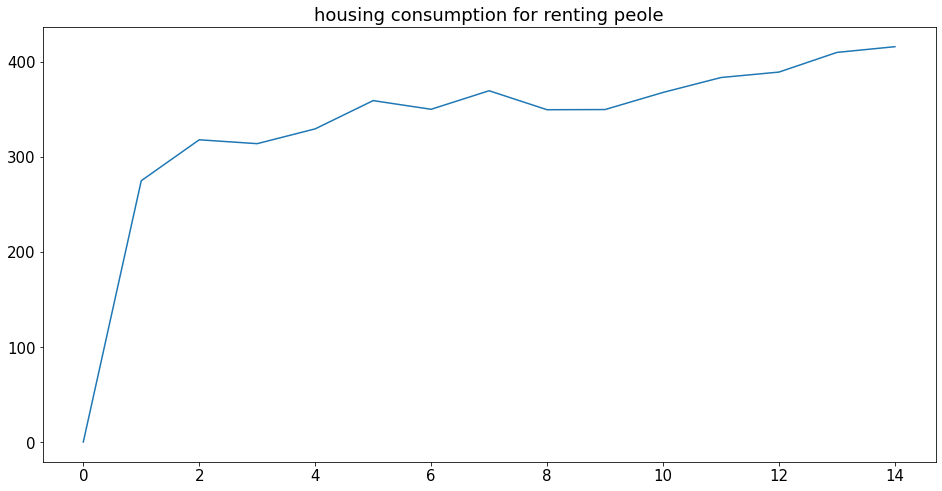

In [9]:
plt.title("housing consumption for renting peole")
plt.plot(hs[:, jnp.where(os.sum(axis = 0)  == 0)[0]].mean(axis = 1), label = "housing")

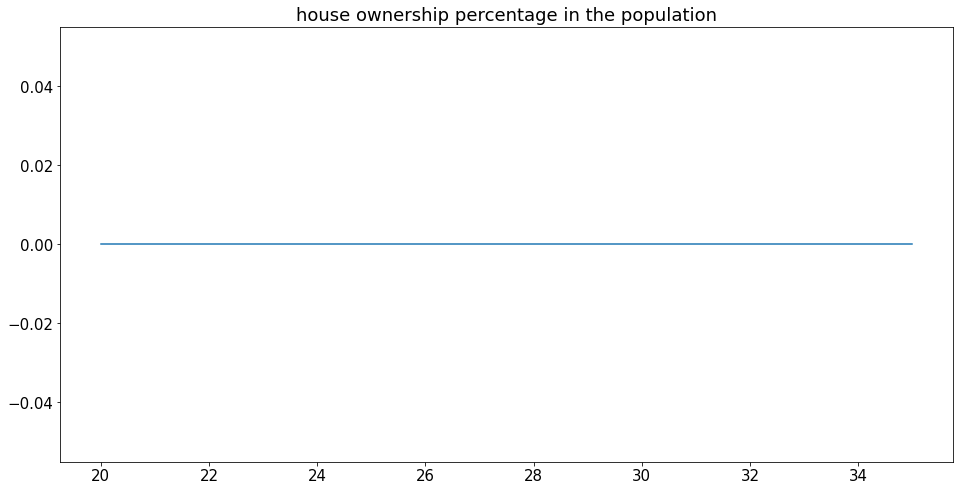

In [10]:
plt.title("house ownership percentage in the population")
plt.plot(range(20, yearCount + 21),(os).mean(axis = 1), label = "owning")

In [11]:
# agent selling time collection
agentTime = []
for t in range(30):
    if ((os[t,:] == 0) & (os[t+1,:] == 1)).sum()>0:
        for agentNum in jnp.where((os[t,:] == 0) & (os[t+1,:] == 1))[0]:
            agentTime.append([t, agentNum])
agentTime = jnp.array(agentTime)

In [12]:
# agent selling time collection
agentHold = []
for t in range(30):
    if ((os[t,:] == 0) & (os[t+1,:] == 0)).sum()>0:
        for agentNum in jnp.where((os[t,:] == 0) & (os[t+1,:] == 0))[0]:
            agentHold.append([t, agentNum])
agentHold = jnp.array(agentHold)

IndexError: Too many indices for array: 2 non-None/Ellipsis indices for dim 1.

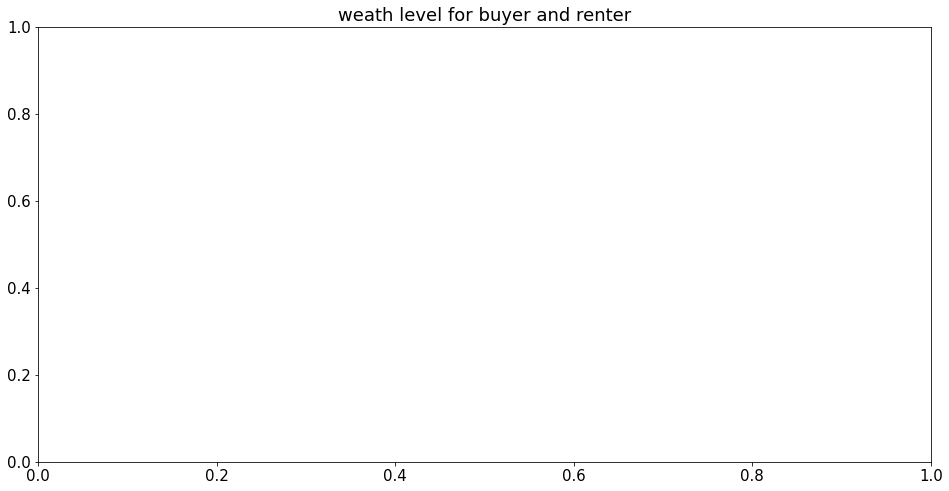

In [13]:
plt.title("weath level for buyer and renter")
www = (os*(ws+H*pt - ms)).sum(axis = 1)/(os).sum(axis = 1)
for age in range(30):
    buyer = agentTime[agentTime[:,0] == age]
    renter = agentHold[agentHold[:,0] == age]
    plt.scatter(age, ws[buyer[:,0], buyer[:,1]].mean(),color =  "b")
    plt.scatter(age, www[age], color = "green")
    plt.scatter(age, ws[renter[:,0], renter[:,1]].mean(),color =  "r")

In [ ]:
plt.title("employement status for buyer and renter")
for age in range(31):
    buyer = agentTime[agentTime[:,0] == age]
    renter = agentHold[agentHold[:,0] == age]
    plt.scatter(age, es[buyer[:,0], buyer[:,1]].mean(),color =  "b")
    plt.scatter(age, es[renter[:,0], renter[:,1]].mean(),color =  "r")

In [ ]:
# At every age
plt.title("Stock Investment Percentage")
plt.plot((os[:yearCount,:]*ks/(ks+bs)).sum(axis = 1)/os[:yearCount,:].sum(axis = 1), label = "owner")
plt.plot(((1-os[:yearCount,:])*ks/(ks+bs)).sum(axis = 1)/(1-os)[:yearCount,:].sum(axis = 1), label = "renter")
plt.legend()

In [ ]:
# At every age
plt.title("Stock Investment Amount")
plt.plot((os[:yearCount,:]*ks).sum(axis = 1)/os[:yearCount,:].sum(axis = 1), label = "owner")
plt.plot(((1-os[:yearCount,:])*ks).sum(axis = 1)/(1-os)[:yearCount,:].sum(axis = 1), label = "renter")
plt.legend()